<a href="https://colab.research.google.com/github/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_1/Feature_Engineering_Celeb_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install scikit-learn
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
clear_output()

## Settings

In [ ]:
base_dir = "base_dir"
csv_attributes_path = os.path.join(base_dir, 'datasets/celeb_a/list_attr_celeba.csv')

__O Problema do Desbalanceamento Multilabel__

Em um cenário multilabel, cada amostra pode ter um ou mais rótulos (classes), o que significa que o modelo precisa lidar com a combinação de múltiplos rótulos ao mesmo tempo. Isso cria uma situação em que o desbalanceamento pode ocorrer em nível de classe individual (ou seja, algumas classes podem ser raras em todo o dataset), em nível de rótulo (onde uma amostra pode ter uma combinação específica de rótulos menos frequentes) ou em nível de instância (onde algumas amostras têm muitos rótulos enquanto outras têm apenas alguns).

Quando há um desbalanceamento significativo, o modelo pode tender a prever as classes mais frequentes corretamente, enquanto ignora as classes menos representadas, prejudicando a capacidade de generalização e levando a uma performance desigual.

__Veja abaixo o total de ocorrências de cada classe no dataset Celeb A completo__

## Loading the data

In [ ]:
df = pd.read_csv(csv_attributes_path).replace(-1, 0)

Classe menos representada: Bald = 4547
Classe mais representada: No_Beard = 169158


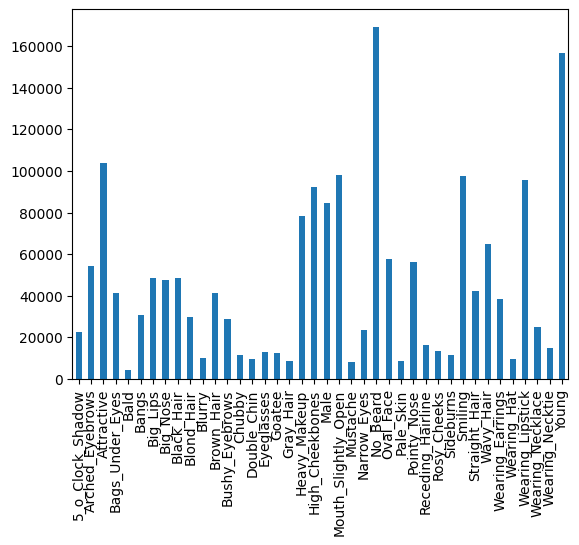

In [ ]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

## Exploratory Data Analysis

A matriz de correlação é um excelente ponto de partida para esta análise. Já é possível encontrar nela pista de variáveis correlacionadas, negativa ou positivamente que devem influenciar no funcionamento do modelo.

`No_beard`, que é um atributo que também pode ser masculino, está inversamente relacionado a alguns tipos de barba, a Male e positivamente relacionado à atributos femininos.

Já é possível encontrar indícios de classes que precisarão de data augmentation estratégico: __por exemplo, algumas características podem não estar presentes nos rostos femininos, mas é possível que mulheres as tenham, e ainda estão pouco presentes no dataset:__ double_chin, eyeglasses, chubby, big_nose, etc.

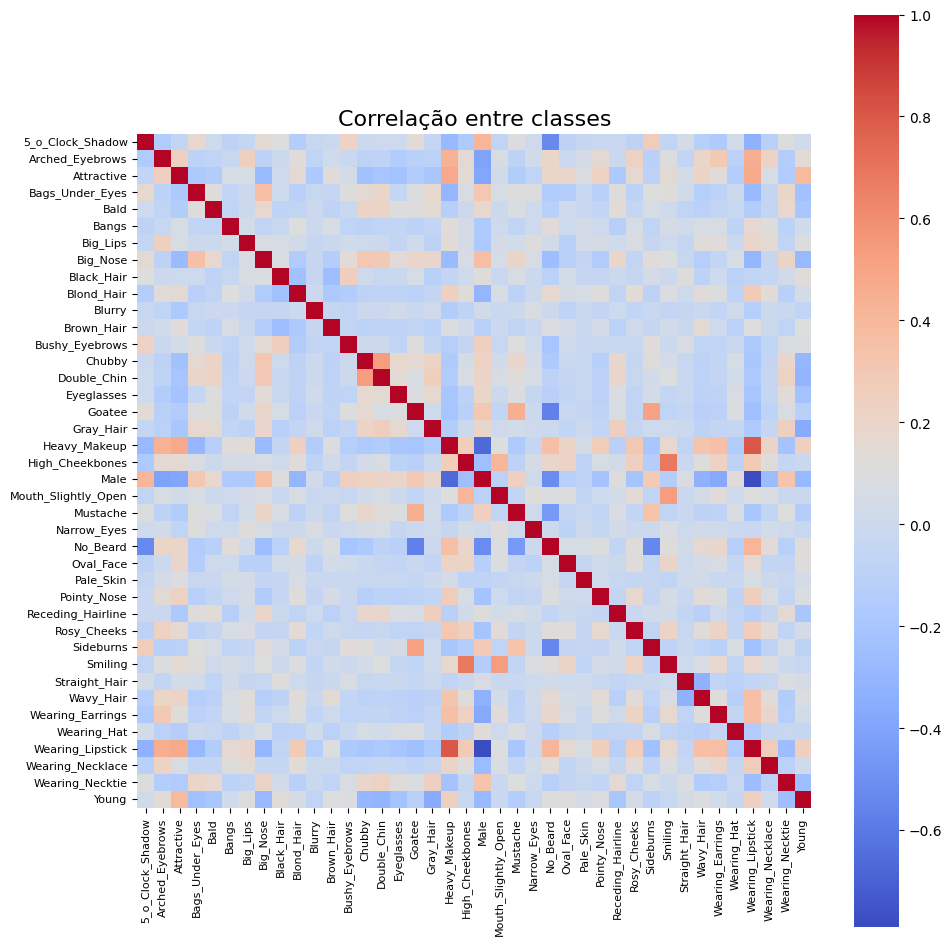

In [ ]:
corr_matrix = df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    xticklabels=True,
    yticklabels=True,
    cbar=True,
    square=True
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.title("Correlação entre classes", fontsize=16)
plt.tight_layout()
plt.show()

Um clustering hierárquico pode ajudar a visualizar melhor essas relações. O número de clusters foi arbitrário.

---

Observe a classe Male e a quais rótulos ela está mais associada. Nesse dataset, geralmente homens possuem uma barba 5_o_clock_shadow, bolsões abaixo dos olhos (acúmulo de gordura), entradas, nariz grande, dentre outros. Com destaque para o cabelo cinza.

---

O cabelo cinza está fortemente associado a classe Male provavelmente por homens nem sempre pintarem os fios grisalhos. Ao analisar o dendograma a seguir, é possível perceber que ter fios cinzas é oposto a ser jovem. Logo, mulheres não jovens, que não possuem cabelo grisalho podem ser classificadas como jovens.

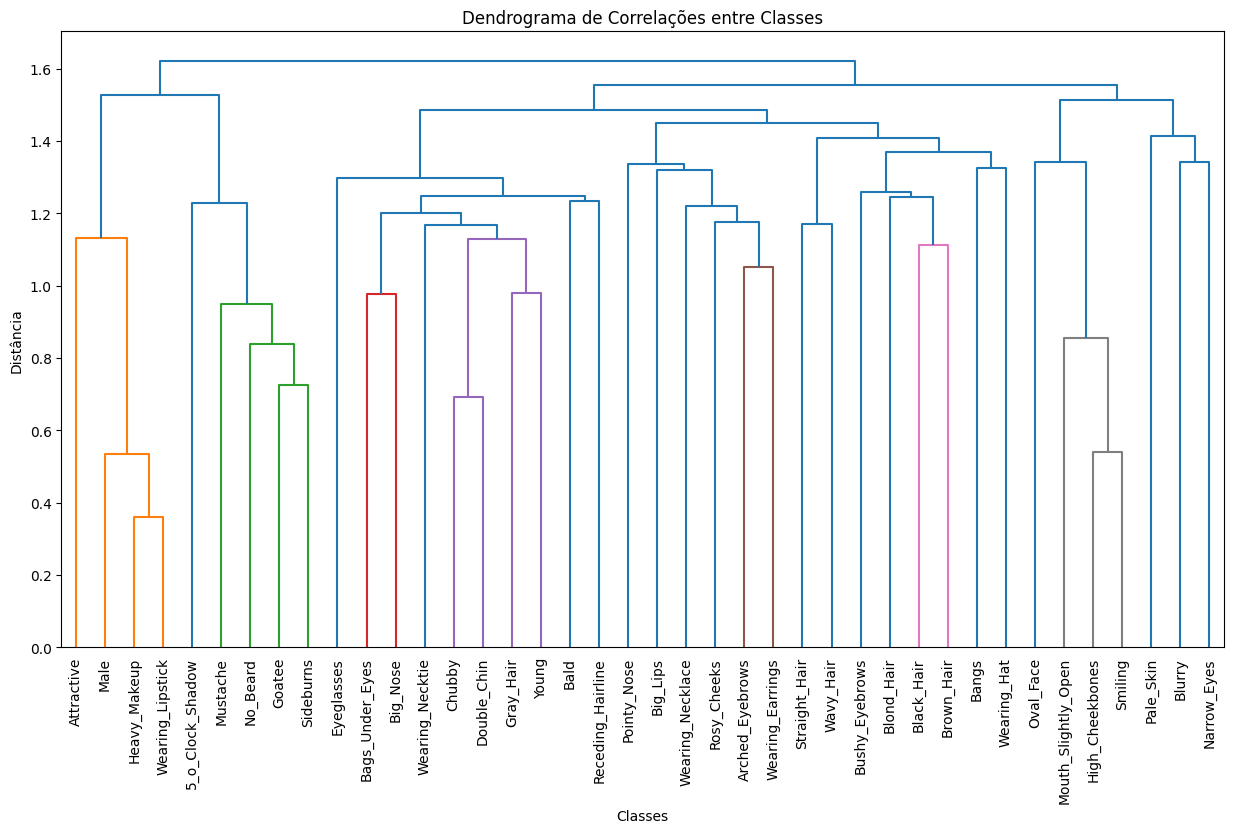

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
clustering = AgglomerativeClustering(
    n_clusters=10,
    metric='precomputed',
    linkage='average'
)
distance_matrix = pdist(1 - abs(corr_matrix.values), metric='euclidean')
Z = linkage(distance_matrix, method='average')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma de Correlações entre Classes")
plt.xlabel("Classes")
plt.ylabel("Distância")
plt.show()


__Vamos analisar o dendogrma__

- O grupo laranja evidencia que a `atratividade`, que é um atributo subjetivo, está mais próxima de atributos que estão fortemente correlacionados à mulheres, ou não Male. A atratividade é um conceito subjetivo, varia entre culturas, e talvez seja adequado retirá-lo.
    
- `Attractive` está positivamente associado ao uso de maquiagem e atributos tipicamente femininos, e possui correlação forte negativa com Male, de acordo com a matriz de correlação.

- Já no grupo verde, que indica estilos de barba, como costeletas, bigode, cavanhaque, os atributos são correlacionados a Male, exceto No_Beard.

- Em relação às cores de cabelo, um cabelo só pode ser loiro, preto, cinza ou castanho. Parece estar ok essa hierarquia. Já o cabelo cinza está associado a ser não jovem: se não tem cabelo cinza é jovem. Mas, nessa base cabelo cinza é mais frequente em homens. O modelo pode entender que uma pessoa não é jovem se tiver cabelo cinza, e como este é mais frequente em homens o modelo pode falhar em identificar mulheres mais idosas.

__Conclusão__

- É importante observar quais características estão nas folhas do dendograma, bem o mapa de correlação, pois estes dão pistas sobre o provável funcionamento do modelo, e pode ajudar a entender quais ajustes e em quais imagens podem ajudar a rede a aprender melhor o problema.

- Ex.: Bangs e uso de chapéu parecem estar bem relacionados. Em um determinado ponto, a imagem será classificada em um dos atributos. Pode acontecer de a rede confundir franja com chapéu e vice-versa.

- __Entretanto, esses ajustes serão mais estratégicos após o treino da rede e inspeção das métricas de classificação.__

## Some feature engineering

__Aplicando as modificações__

In [ ]:
df = df.drop(
    columns=['Attractive']
)

__Clusterizando novamente__

dendograma após a remoção dos atributos No_Beard e Attractive.

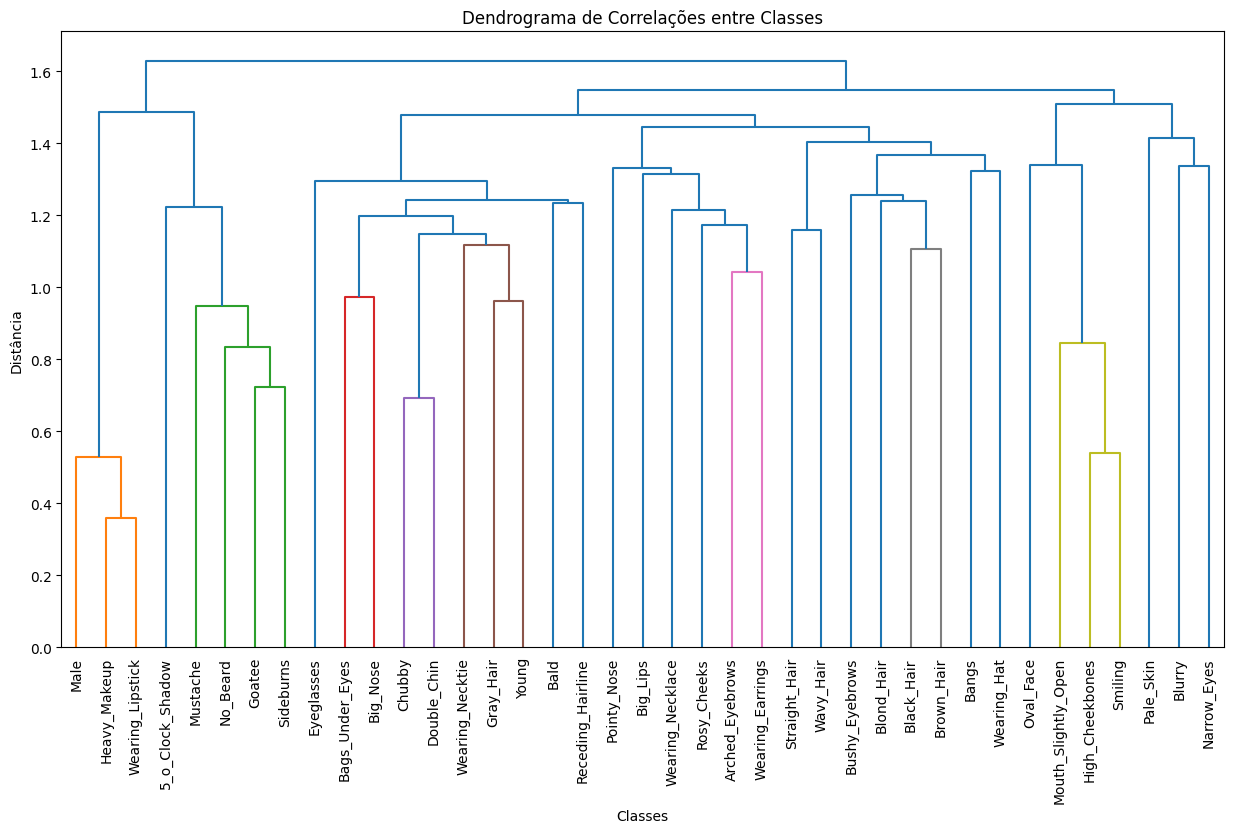

In [ ]:
corr_matrix = df.iloc[:, 1:].corr()
clustering = AgglomerativeClustering(
    n_clusters=10,
    metric='precomputed',
    linkage='average'
)
distance_matrix = pdist(1 - abs(corr_matrix.values), metric='euclidean')
Z = linkage(distance_matrix, method='average')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma de Correlações entre Classes")
plt.xlabel("Classes")
plt.ylabel("Distância")
plt.show()


__Vamos ver a nova distribuição das 39 classes restantes__

- Observe que No_Beard ainda é a classe mais representada, seguida de `Young`.

Classe menos representada: Bald = 4547
Classe mais representada: No_Beard = 169158


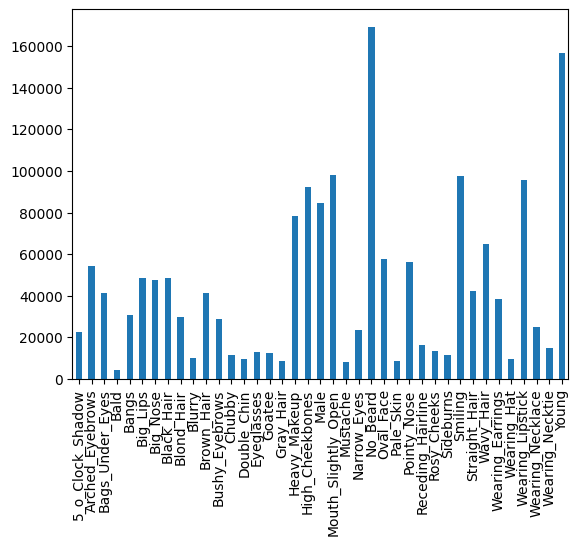

In [ ]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

## Selecting the data

__Encontrando uma combinação de amostras equilibrada__

- A base é muito grande, e serão utilizadas no primeiro treino no máximo 3.900 imagens, 100 por classe, e com data augmentation geral e básico para toda a base de treino.

- O objetivo aqui é escolher aleatoriamente conjuntos de imagens que resulte em uma distribuição de classes mais equilibrada.

In [ ]:
X = df.loc[:, 'image_id'].values.reshape(-1, 1)
y = df.iloc[:, 1:].values

std mean inicial: 0.8877993916255152
Iteração 0: Melhor desvio padrão relativo = 0.7341
Iteração 1: Melhor desvio padrão relativo = 0.7292
Iteração 5: Melhor desvio padrão relativo = 0.7286
Iteração 12: Melhor desvio padrão relativo = 0.7261
Iteração 16: Melhor desvio padrão relativo = 0.7227
Iteração 17: Melhor desvio padrão relativo = 0.7226
Parada antecipada após 20 iterações sem melhora.


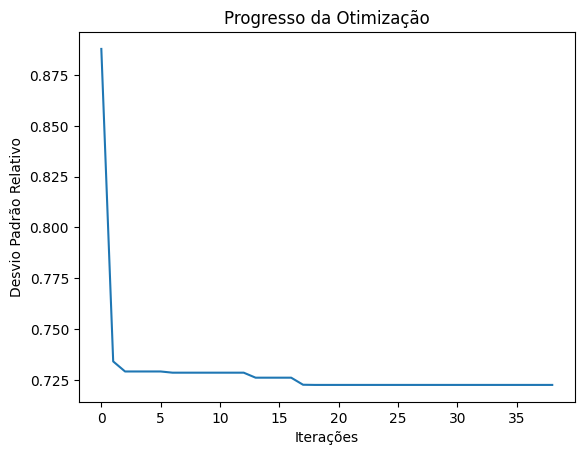

**************************************************
Melhor conjunto encontrado com desvio padrão relativo: 0.7226
Tamanho do novo conjunto: 3900 imagens


In [ ]:
def find_balanced_subset(X, y, num_iterations=100, per_class=100, patience=10, seed=42):
    np.random.seed(seed)

    def calculate_std_relative(y):
        return np.std(np.sum(y, axis=0)) / np.mean(np.sum(y, axis=0))

    def calculate_probabilities(y, current_distribution):
        class_counts = np.sum(y, axis=0)
        target_distribution = current_distribution + np.sum(y, axis=0)
        class_weights = 1 / (target_distribution + 1e-6)
        sample_weights = np.dot(y, class_weights)
        return sample_weights / np.sum(sample_weights)

    # Inicialização
    best_y_std_mean = calculate_std_relative(y)
    X_best, y_best = X, y
    current_distribution = np.zeros(y.shape[1])
    p = calculate_probabilities(y, current_distribution)

    print('std mean inicial:', best_y_std_mean)
    no_improvement_count = 0
    improvements = [best_y_std_mean]

    for i in range(num_iterations):
        # Seleção de índices
        selected_indices = np.random.choice(
            range(len(X)), size=per_class * y.shape[1], replace=False, p=p
        )
        selected_indices = np.unique(selected_indices)

        # Novo subconjunto
        y_sub = y[selected_indices]
        X_sub = [X[idx] for idx in selected_indices]
        y_sub_std_mean = calculate_std_relative(y_sub)

        # Atualização do melhor conjunto
        if y_sub_std_mean < best_y_std_mean:
            best_y_std_mean = y_sub_std_mean
            X_best, y_best = X_sub, y_sub
            current_distribution = np.sum(y_best, axis=0)
            p = calculate_probabilities(y, current_distribution)
            no_improvement_count = 0
            print(f"Iteração {i}: Melhor desvio padrão relativo = {best_y_std_mean:.4f}")
        else:
            no_improvement_count += 1

        improvements.append(best_y_std_mean)

        if no_improvement_count >= patience:
            print(f"Parada antecipada após {patience} iterações sem melhora.")
            break

    plt.plot(improvements)
    plt.xlabel('Iterações')
    plt.ylabel('Desvio Padrão Relativo')
    plt.title('Progresso da Otimização')
    plt.show()
    return X_best, y_best, best_y_std_mean

X_best, y_best, best_std_relative = find_balanced_subset(X, y, num_iterations=10000, per_class=100, patience=20)

print('*' * 50)
print(f"Melhor conjunto encontrado com desvio padrão relativo: {best_std_relative:.4f}")
print(f"Tamanho do novo conjunto: {len(X_best)} imagens")

In [ ]:
df_2 = df.loc[
    df.image_id.isin(np.array(X_best).reshape(-1)), :
]
df_2.to_csv(os.path.join(base_dir, 'datasets/celeb_a/attr_celeb_a_sample.csv'), index=False)

Classe menos representada: Bald = 4547
Classe mais representada: No_Beard = 169158


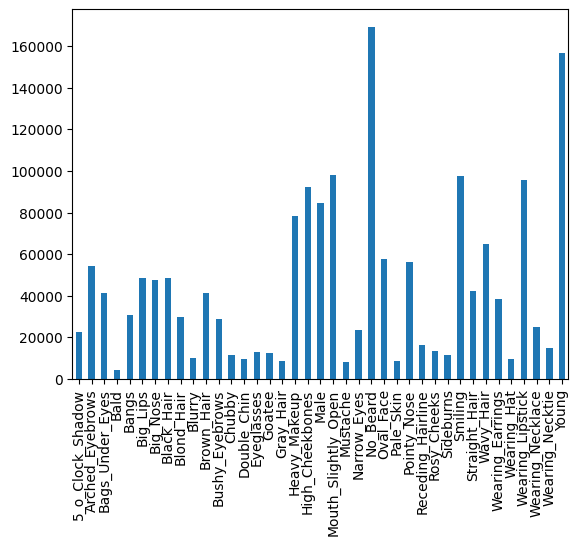

In [ ]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

No conjunto selecionado é possível perceber pelo gráfico abaixo, que as classes menos presentes tiveram sua presença aumentada.

Classe menos representada: Blurry = 221
Classe mais representada: No_Beard = 2920


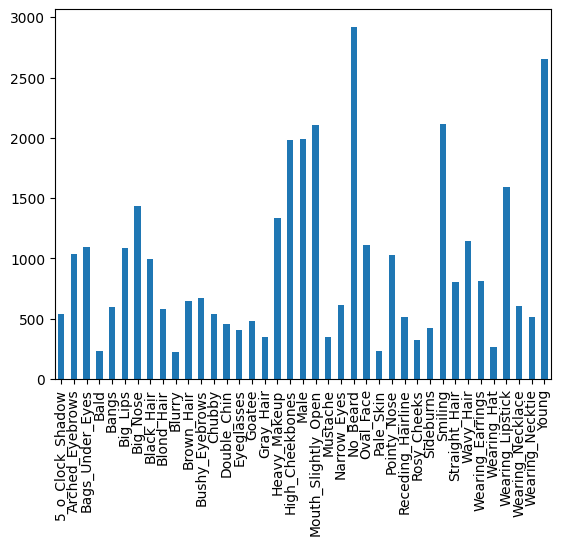

In [ ]:
print(f'Classe menos representada: {df_2.columns[1:][df_2.iloc[:, 1:].sum().argmin()]} = {df_2.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df_2.columns[1:][df_2.iloc[:, 1:].sum().argmax()]} = {df_2.iloc[:, 1:].sum().max()}')
df_2.iloc[:, 1:].sum().plot(kind='bar');

## Conclusão

1. A partir dessa análise inicial já é esperado que o modelo terá dificuldade em diferenciar faces jovens de não jovens. É esperado que mulheres sejam classificadas como jovem mais frequentemente do que deveria, pois a principal variável associada à idade é o cabelo grisalho, que é mais frequente em homens.

2. Também, outras características relacionadas à idade estão mais atreladas aos homens, como bolsas abaixo dos olhos, papada, e um rosto com aparência mais rechonchuda. Estas são características que mulheres também podem apresentar, então pode acontecer de mulheres com essas características serem classificadas como homens. Neste caso, deve-se observar os exemplos usados no treinamento e fazer um data augmentation estratégico para cada classe.

3. Por fim, a primeira versão do modelo deve ser treinada, e a partir da inspeção das métricas poderei avaliar qual o ponto de melhoria mais significativo. De qualquer forma, com essa análise é possível saber o que esperar do modelo.

__Próximo passo__: treino da rede com as 3.900 imagens selecionadas e 39 variáveis.